# Graph algorithms with `networkx`

Once we have linked data represented as a KG, we can begin to use *graph algorithms* and *network analysis* on the data.
Perhaps the most famous of these is [PageRank](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) which helped launch Google, also known as a stochastic variant of *eigenvector centrality*.

We'll use the [`networkx`](https://networkx.org/) library to run graph algorithms, since `rdflib` lacks support for this.
Note that `networkx` requires its own graph representation in memory, where there is a relatively simplified structure of the KG.
For example, in `networkx` there is one edge that connects two nodes, while in `rdflib` there can be multiple relations (predicates) between RDF subjects and objects.

Based on a branch of mathematics related to linear algebra called [*algebraic graph theory*](https://en.wikipedia.org/wiki/Algebraic_graph_theory), it's possible to convert between a simplified graph (such as in `networkx`) and its matrix representation.
Then many of the popular graph algorithms can be optimized in terms of matrix operations – often leading to orders of magnitude in performance increases.
Many of the algorithms implemented within `networkx` rely on these matrix transforms.
In contrast, the more general form of mathematics for representing complex graphs and networks involves using [*tensors*](https://en.wikipedia.org/wiki/Tensor) instead of matrices.
For example, you may have heard that word `tensor` used in association with neural networks?

See also:

  * <https://towardsdatascience.com/10-graph-algorithms-visually-explained-e57faa1336f3>
  * <https://web.stanford.edu/class/cs97si/06-basic-graph-algorithms.pdf>
  * <https://networkx.org/documentation/stable/reference/algorithms/index.html>
  
  
The `kglab` library converts from `rdflib` representation into `networkx`, then helps convert back the results from graph algorithm analysis.
In that case, we must choose which relations to include in our analysis.

To start, let's load our recipe KG:

In [1]:
import kglab

namespaces = {
    "wtm": "http://purl.org/heals/food/",
    "ind": "http://purl.org/heals/ingredient/",
    "skos": "https://www.w3.org/2004/02/skos/core#",
    "nom": "https://github.com/DerwenAI/kglab/wiki/Vocab#",
    }

kg = kglab.KnowledgeGraph(
    name = "A recipe KG example based on Food.com",
    base_uri = "https://www.food.com/recipe/",
    language = "en",
    namespaces = namespaces,
    )

kg.load_ttl("tmp.ttl")

Now we'll run a SPARQL query to build a *subgraph* of recipe URLs and their related ingredients.
In other words, let's start with a relatively simple graph to illustrate some graph algorithms:

In [2]:
query = """
    SELECT ?rec ?ind
    WHERE {
        ?rec rdf:type wtm:Recipe .
        ?rec wtm:hasIngredient ?ind .
    }
    """

Next, we'll use result set from query to load the `networkx` graph:

In [3]:
import networkx as nx
g = nx.Graph()

for row in kg.query(query):
    rec, ind = row

    s_label = rec.n3(kg._g.namespace_manager)
    s_id = kg.get_node_id(rec)

    o_label = ind.n3(kg._g.namespace_manager)
    o_id = kg.get_node_id(ind)

    print("{}: {}\n {}: {}\n".format(s_id, s_label, o_id, o_label))

    g.add_node(s_id, bipartite=0)
    g.add_node(o_id, bipartite=1)
    g.add_edge(s_id, o_id)

0: <https://www.food.com/recipe/180624>
 1: ind:Butter

0: <https://www.food.com/recipe/180624>
 2: ind:Salt

0: <https://www.food.com/recipe/180624>
 3: ind:ChickenEgg

4: <https://www.food.com/recipe/437729>
 1: ind:Butter

4: <https://www.food.com/recipe/437729>
 5: ind:WhiteSugar

4: <https://www.food.com/recipe/437729>
 6: ind:AllPurposeFlour

7: <https://www.food.com/recipe/40772>
 1: ind:Butter

7: <https://www.food.com/recipe/40772>
 2: ind:Salt

7: <https://www.food.com/recipe/40772>
 6: ind:AllPurposeFlour

7: <https://www.food.com/recipe/40772>
 3: ind:ChickenEgg

7: <https://www.food.com/recipe/40772>
 8: ind:CowMilk

9: <https://www.food.com/recipe/262038>
 6: ind:AllPurposeFlour

9: <https://www.food.com/recipe/262038>
 2: ind:Salt

9: <https://www.food.com/recipe/262038>
 1: ind:Butter

9: <https://www.food.com/recipe/262038>
 8: ind:CowMilk

9: <https://www.food.com/recipe/262038>
 3: ind:ChickenEgg

10: <https://www.food.com/recipe/82226>
 5: ind:WhiteSugar

10: <https

## Simple graph measures

A very simple test in `networkx` is to determine whether or not the graph is fully *connected*.
In other words, are there nodes that aren't linked to the remainder of the graph?

In [4]:
nx.is_connected(g)

True

There are ways to "measure" graphs, for example using [*graph diameter*](https://mathworld.wolfram.com/GraphDiameter.html) which is defined by *Wolfram MathWorld* as:

> the largest number of vertices which must be traversed in order to travel from one vertex to another when paths which backtrack, detour, or loop are excluded from consideration

Also called the "longest shorted path" within the graph.
A smaller graph diameter indicates lots of interconnections, while a larger measure indicates relatively sparser connections:

In [5]:
import networkx.algorithms.distance_measures as nx_measure

nx_measure.diameter(g)

5

The way that we've built this subgraph, it has two distinct and independent sets of nodes – namely, the *recipes* and the *ingredients*.
In other words, the recipes only link to ingredients, and the ingredients only link to recipes.
This fits the formal definitions of a [*bipartite graph*](https://en.wikipedia.org/wiki/Bipartite_graph), which is important for working AI applications such as recommender systems, search engines, etc.

Let's decompose our subgraph into its two sets of nodes:

In [6]:
from networkx.algorithms import bipartite

rec_nodes, ind_nodes = bipartite.sets(g)

print("recipes\n", rec_nodes, "\n")
print("ingredients\n", ind_nodes)

recipes
 {0, 4, 7, 9, 10, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,

## Centrality and connectedness

Let's make good use of those bipartite sets for filtering results from other algorithms.

Some of the ingredients are used more frequently than others.
In very simple graphs we could use statistical frequency counts to measure that, although a more general purpose approach is to measure the *degree centrality*, i.e., "How connected is each node?"
This is similar to calculating PageRank:

In [7]:
results = nx.degree_centrality(g)
ind_rank = {}

for node_id, rank in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if node_id in ind_nodes:
        node = kg.get_node(node_id)
        ind_rank[node_id] = rank
        print("{:6.3f} {}".format(rank, kg.get_node_label(node)))

 0.745 ind:AllPurposeFlour
 0.667 ind:ChickenEgg
 0.620 ind:Salt
 0.576 ind:Butter
 0.518 ind:CowMilk
 0.388 ind:WhiteSugar
 0.275 ind:Water
 0.212 ind:VanillaExtract
 0.059 ind:BlackPepper
 0.043 ind:BrownSugar
 0.035 ind:OliveOil
 0.035 ind:WholeWheatFlour
 0.024 ind:AppleCiderVinegar
 0.012 ind:Bacon
 0.012 ind:Honey
 0.008 ind:Garlic


We can plot the graph directly from `networkx` using [`matplotlib`](https://matplotlib.org/):

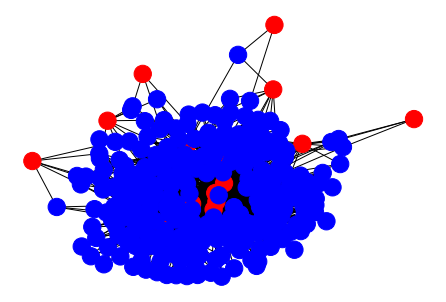

In [8]:
import matplotlib.pyplot as plt

color = [ "red" if n in ind_nodes else "blue" for n in g.nodes()]

nx.draw(g, node_color=color, with_labels=False)
plt.show()

Next, let's determine the [*k-cores*](https://en.wikipedia.org/wiki/Degeneracy_(graph_theory)#k-Cores) which are "maximal connected subgraphs" such that each node has `k` connections:

In [9]:
core_g = nx.k_core(g)
core_g.nodes()

NodeView((128, 1, 2, 3, 130, 5, 6, 134, 8, 136, 11, 18, 148, 22, 150, 24, 29, 160, 33, 168, 43, 175, 55, 56, 57, 184, 192, 67, 68, 196, 74, 209, 210, 83, 88, 92, 93, 97, 98, 227, 102, 235, 237, 240, 121, 126))

Now let's plot those k-core nodes in a simplified visualization, which helps reveal the interconnections:

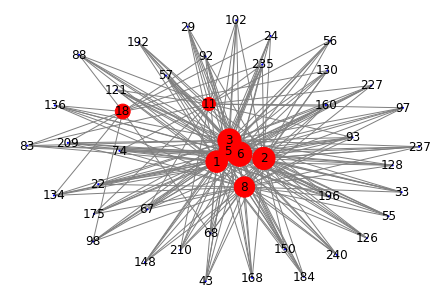

In [10]:
color = [ "red" if n in ind_nodes else "blue" for n in core_g ]
size = [ ind_rank[n] * 800 if n in ind_nodes else 1 for n in core_g ]

nx.draw(core_g, node_color=color, node_size=size, edge_color="gray", with_labels=True)
plt.show()

In [11]:
for node_id, rank in sorted(ind_rank.items(), key=lambda item: item[1], reverse=True):
    if node_id in core_g:
        node = kg.get_node(node_id)
        print("{:3} {:6.3f} {}".format(node_id, rank, kg.get_node_label(node)))

  6  0.745 ind:AllPurposeFlour
  3  0.667 ind:ChickenEgg
  2  0.620 ind:Salt
  1  0.576 ind:Butter
  8  0.518 ind:CowMilk
  5  0.388 ind:WhiteSugar
 18  0.275 ind:Water
 11  0.212 ind:VanillaExtract


In other words, as the popular ingredients for recipes in our graph tend to be: `flour`, `eggs`, `salt`, `butter`, `milk`, `sugar` – although not so much `water`.

We can show a similar ranking with PageRank, although with different weights:

In [12]:
page_rank = nx.pagerank(g)

for node_id, rank in sorted(ind_rank.items(), key=lambda item: item[1], reverse=True):
    if node_id in core_g:
        node = kg.get_node(node_id)
        label = kg.get_node_label(node)
        print("{:3} {:6.3f} {:6.3f} {}".format(node_id, rank, page_rank[node_id], label))

  6  0.745  0.081 ind:AllPurposeFlour
  3  0.667  0.072 ind:ChickenEgg
  2  0.620  0.067 ind:Salt
  1  0.576  0.062 ind:Butter
  8  0.518  0.055 ind:CowMilk
  5  0.388  0.042 ind:WhiteSugar
 18  0.275  0.031 ind:Water
 11  0.212  0.023 ind:VanillaExtract


## Multi-scale structure

Another interesting topic about analyzing graphs is to understand how their structure changes as you "zoom out" to different levels of detail.
This is generally described as *multi-scale struture* in a graph.
The general case of this kind of analysis involves an area of mathematics called [*persistent homology*](https://en.wikipedia.org/wiki/Persistent_homology), which is far beyond the scope of this tutorial.
While relatively advanced, it finds good use in online marketing and also in ways to blend KGs with machine learning.

A much simpler notion is called [*onion decomposition*](https://www.nature.com/articles/srep31708) where we can "peel off layers" of a graph, relatively speaking, by removing *k-cores* –– not unlike removing the most connected nodes first along with their close connectsions. In `networkx` this can be performed using the `onion_layers()` function:

In [13]:
results = nx.onion_layers(g)

for node_id, core_number in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if node_id in ind_nodes:
        node = kg.get_node(node_id)
        print("{:3} {:3} {}".format(node_id, core_number, kg.get_node_label(node)))

 18  12 ind:Water
  8  12 ind:CowMilk
  1  12 ind:Butter
  2  12 ind:Salt
  3  12 ind:ChickenEgg
  5  12 ind:WhiteSugar
  6  12 ind:AllPurposeFlour
 11  12 ind:VanillaExtract
 13   9 ind:BlackPepper
 38   6 ind:OliveOil
 40   6 ind:AppleCiderVinegar
 63   6 ind:WholeWheatFlour
 15   5 ind:BrownSugar
 14   3 ind:Bacon
 64   3 ind:Honey
167   1 ind:Garlic


---

## Exercises

**Exercise 1:**
    
Find the `node_id` number for the node that represents the `"black pepper"` ingredient.

Then use the [`bfs_edges()`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.breadth_first_search.bfs_edges.html#networkx.algorithms.traversal.breadth_first_search.bfs_edges) function with its source set to `node_id` to perform a *breadth first search* traversal of the graph to depth `2` to find the closest neighbors and print their labels.

**Exercise 2:**

Use the [`dfs_edges()`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.depth_first_search.dfs_edges.html#networkx.algorithms.traversal.depth_first_search.dfs_edges) function to perform a *depth first search* with the same parameters.

**Exercise 3:**

Find the [*shortest path*](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html) that connects between the node for "black pepper" and the node for "honey", then print the labels for each node in the path.